In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely import ops
from geographiclib.geodesic import Geodesic
from shapely.geometry import LineString, MultiLineString
from scipy.ndimage.filters import gaussian_filter

def raster_filter_range(raster0, g1, g2):
    raster = raster0.copy()
    raster.values = raster.values.astype(np.float32)
    raster.values = gaussian_filter(raster.values,g1) - gaussian_filter(raster.values,g2)
    return raster

# helper function
def segmentize(line):
    return list(map(LineString, zip(line.coords[:-1], line.coords[1:])))

def inverse_radian_km(geom):
    # [[lon0, lat0], [lon1, lat1]]
    coords = np.asarray(geom.coords).ravel()
    #g = geod.Inverse(float(xy0.y), float(xy0.x), float(xy1.y), float(xy1.x))
    g = geod.Inverse(coords[1], coords[0], coords[3], coords[2])
    radian = np.pi*(90 + g['azi1'])/180
    radian = radian if radian<=np.pi else radian-2*np.pi
    return (radian, g['s12']/1000.0)

def angle_radian(geom):
    return inverse_radian_km(geom)[0]

def length_km(geom):
    return inverse_radian_km(geom)[1]

In [2]:
# plotting modules
import matplotlib.pyplot as plt
from matplotlib import cm, colors
%matplotlib inline

## Define Parameters

In [3]:
# Gaussian filter band width
dsigmakm = 20
# iso interval, m
interval = 10
# Gaussian filter band cental sigma, km
sigmaskm = np.linspace(20,980,49)
sigmaskm

array([ 20.,  40.,  60.,  80., 100., 120., 140., 160., 180., 200., 220.,
       240., 260., 280., 300., 320., 340., 360., 380., 400., 420., 440.,
       460., 480., 500., 520., 540., 560., 580., 600., 620., 640., 660.,
       680., 700., 720., 740., 760., 780., 800., 820., 840., 860., 880.,
       900., 920., 940., 960., 980.])

## Read Raster

In [4]:
# regridded from GEBCO 2019
da = xr.open_dataarray('GEBCO_2019.15min.nc').squeeze(drop=True)
da

<xarray.DataArray 'elevation' (lat: 720, lon: 1440)>
[1036800 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float64 -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9
Attributes:
    long_name:           Elevation relative to sea level
    sdn_parameter_name:  Sea floor height (above mean sea level) {bathymetric...
    sdn_parameter_urn:   SDN:P01::ALATZZ01
    sdn_uom_name:        Metres
    sdn_uom_urn:         SDN:P06::ULAA
    standard_name:       height_above_reference_ellipsoid
    units:               m

sigmakm 40.0
radius range 1.2 2.0
-1190.8798828125 1728.18994140625
0...10...20...30...40...50...60...70...80...90...100 - done.
geometries 180897
geometries 5327091


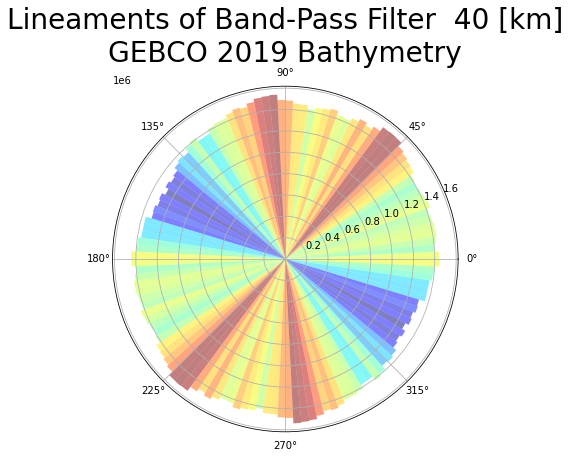

sigmakm 60.0
radius range 2.0 2.8
-969.61865234375 1143.941650390625
0...10...20...30...40...50...60...70...80...90...100 - done.
geometries 64888
geometries 3077321


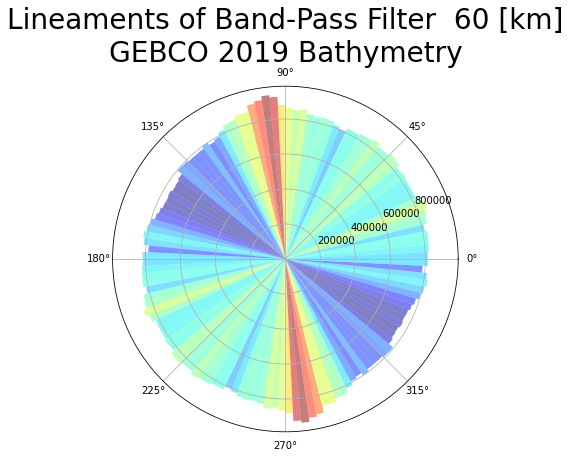

sigmakm 80.0
radius range 2.8 3.6
-719.84228515625 696.883544921875
0...10...20...30...40...50...60...70...80...90...100 - done.
geometries 31928
geometries 2078784


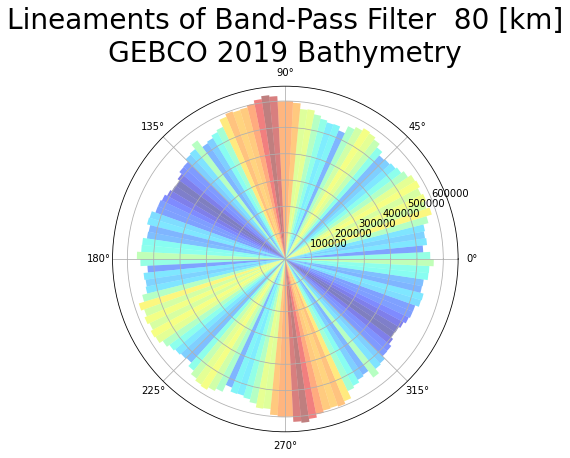

sigmakm 100.0
radius range 3.6 4.4
-511.091064453125 517.489013671875
0...10...20...30...40...50...60...70...80...90...100 - done.
geometries 18667
geometries 1537322


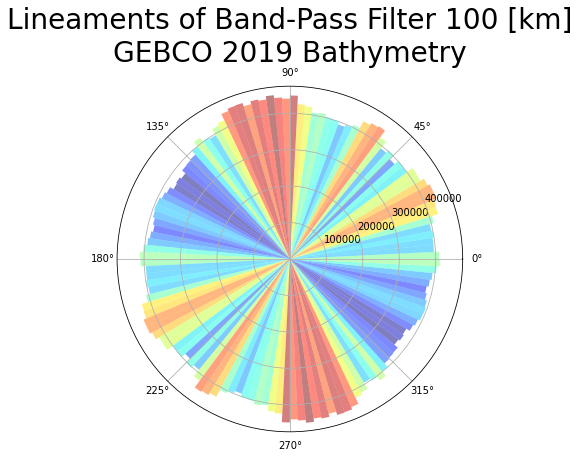

sigmakm 120.0
radius range 4.4 5.2
-412.330078125 451.0335693359375
0...10...20...30...40...50...60...70...80...90...100 - done.
geometries 12074
geometries 1204551


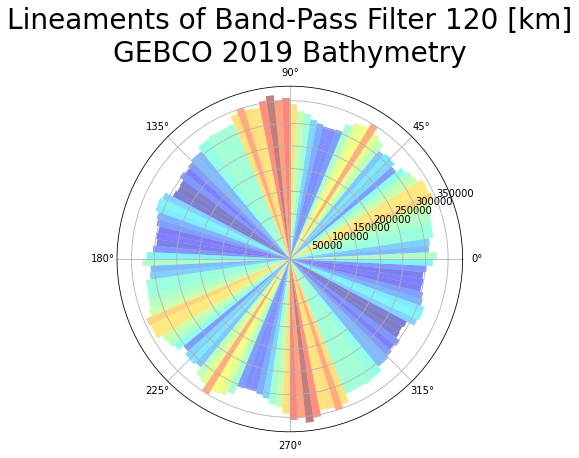

sigmakm 140.0
radius range 5.2 6.0
-359.721923828125 380.83837890625
0...10...20...30...40...50...60...70...80...90...100 - done.
geometries 8460
geometries 983387


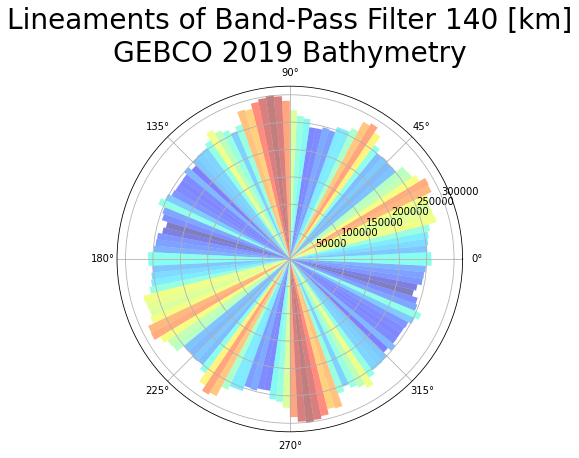

sigmakm 160.0
radius range 6.0 6.8
-320.671630859375 353.4775390625
0...10...20...30...40...50...60...70...80...90...100 - done.
geometries 6246
geometries 826409


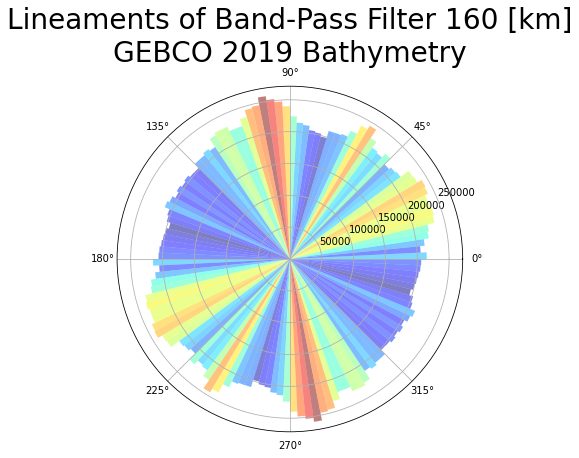

sigmakm 180.0
radius range 6.8 7.6
-299.504150390625 320.623779296875
0...10...20...30...40...50...60...70...80...90...100 - done.
geometries 4781
geometries 709512


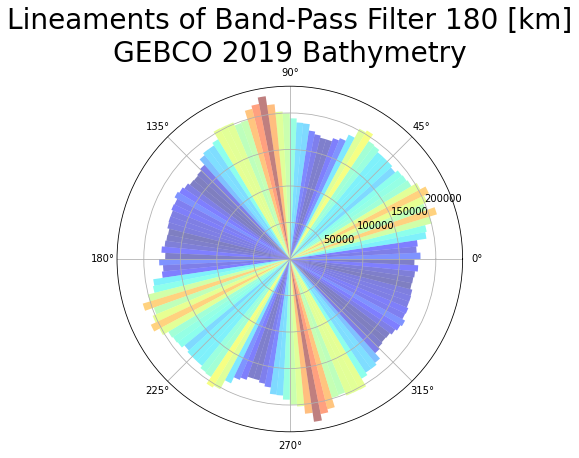

sigmakm 200.0
radius range 7.6 8.4
-279.07373046875 287.697998046875
0...10...20...30...40...50...60...70...80...90...100 - done.
geometries 3798
geometries 619140


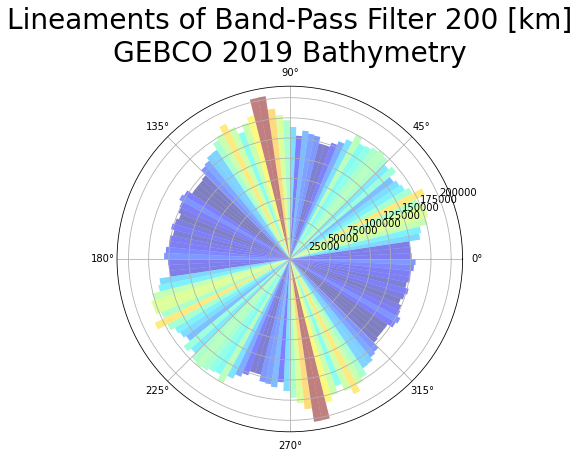

sigmakm 220.0
radius range 8.4 9.2
-259.44873046875 256.4344482421875
0...10...20...30...40...50...60...70...80...90...100 - done.
geometries 3064
geometries 546874


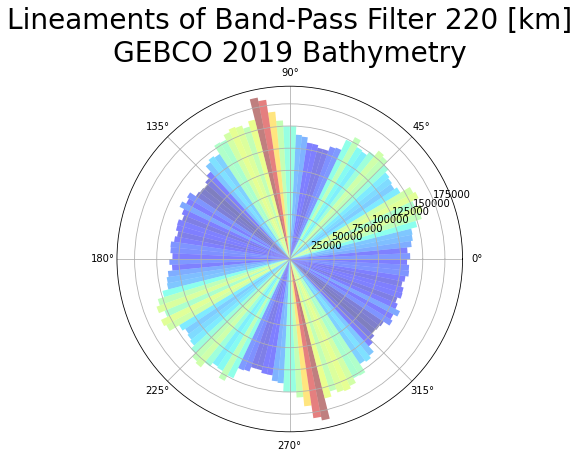

sigmakm 240.0
radius range 9.2 10.0
-240.68359375 228.991943359375
0...10...20...30...40...50...60...70...80...90...100 - done.
geometries 2513
geometries 488259


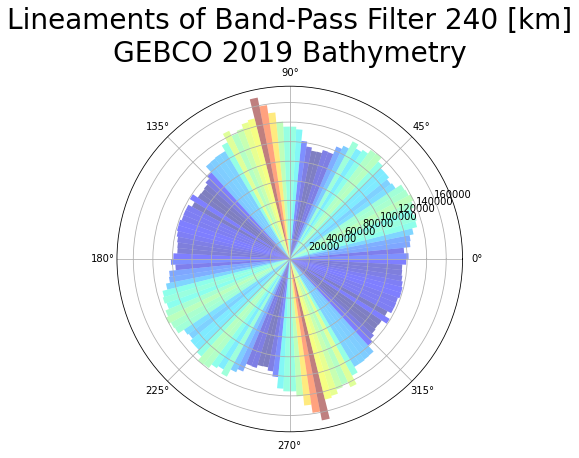

sigmakm 260.0
radius range 10.0 10.8
-222.678466796875 209.116455078125
0...10...20...30...40...50...60...70...80...90...100 - done.
geometries 2094
geometries 439800


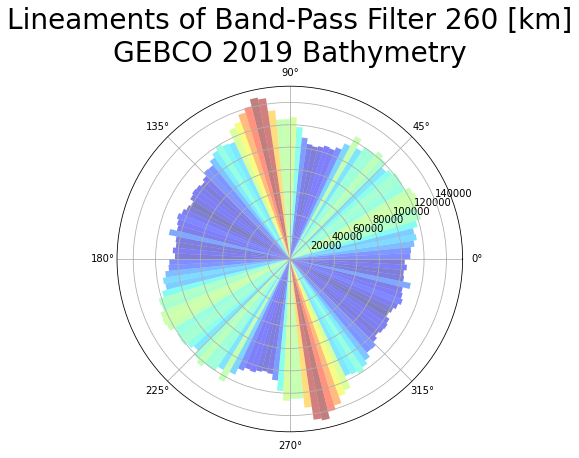

sigmakm 280.0
radius range 10.8 11.6
-205.7021484375 192.226318359375
0...10...20...30...40...50...60...70...80...90...100 - done.
geometries 1814
geometries 399514


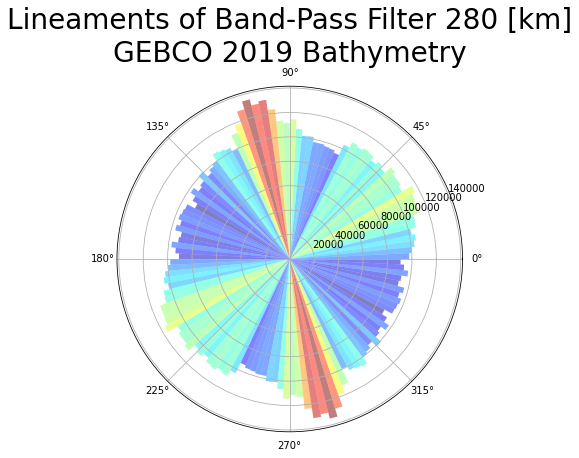

sigmakm 300.0
radius range 11.6 12.4
-189.911865234375 177.7574462890625
0...10...20...30...40...50...60...70...80...90...100 - done.
geometries 1556
geometries 363828


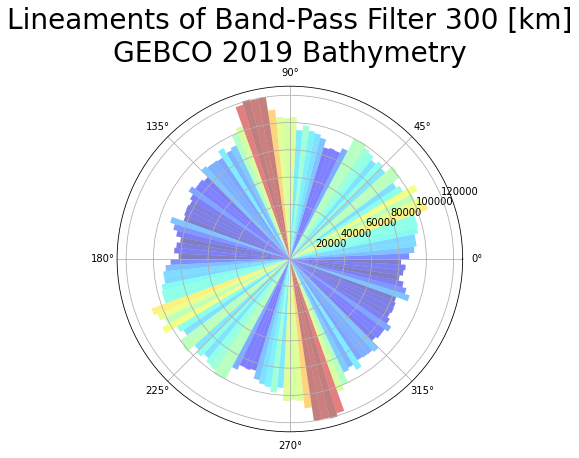

sigmakm 320.0
radius range 12.4 13.2
-175.130615234375 164.0074462890625
0...10...20...30...40...50...60...70...80...90...100 - done.
geometries 1343
geometries 333587


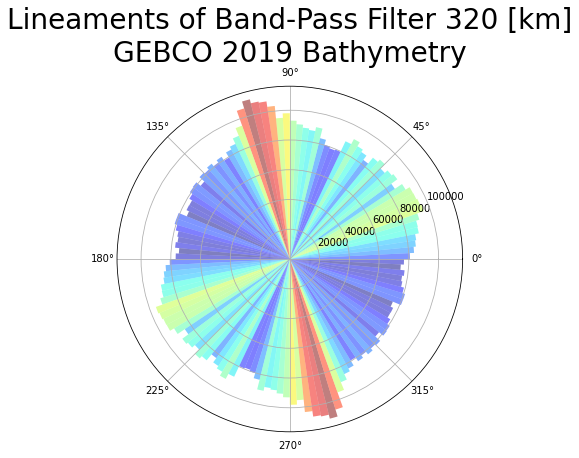

sigmakm 340.0
radius range 13.2 14.0
-161.334228515625 151.0860595703125
0...10...20...30...40...50...60...70...80...90...100 - done.
geometries 1178
geometries 307254


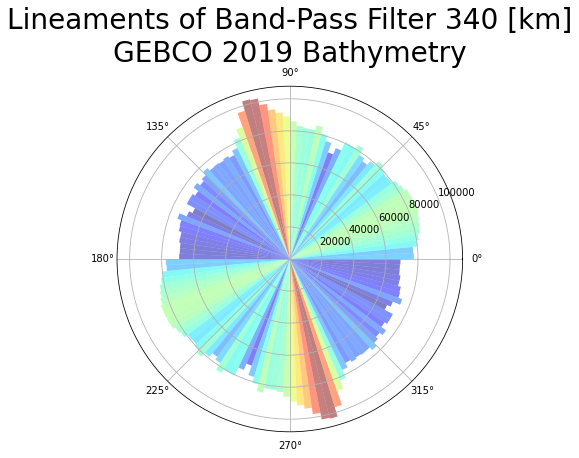

sigmakm 360.0
radius range 14.0 14.8
-148.605712890625 139.3709716796875
0...10...20...30...40...50...60...70...80...90...100 - done.
geometries 1024
geometries 283305


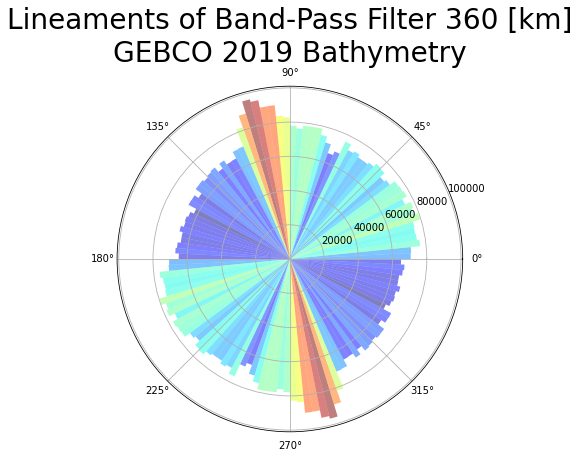

sigmakm 380.0
radius range 14.8 15.6
-136.86328125 128.5245361328125
0...10...20...30...40...50...60...70...80...90...100 - done.
geometries 928
geometries 263287


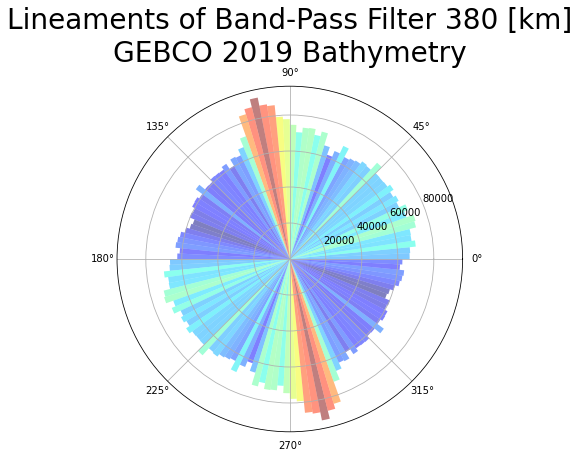

sigmakm 400.0
radius range 15.6 16.4
-126.128662109375 118.59576416015625
0...10...20...30...40...50...60...70...80...90...100 - done.
geometries 823
geometries 245470


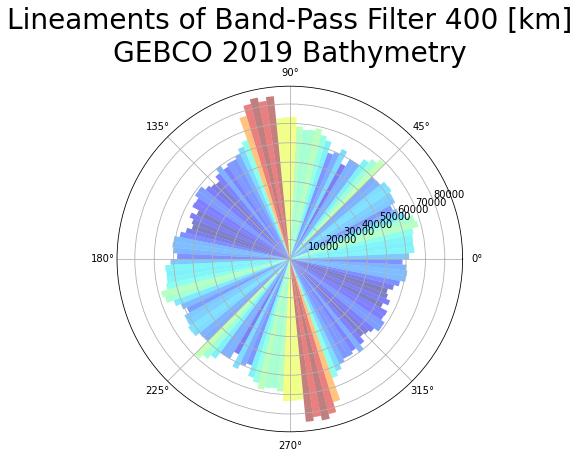

sigmakm 420.0
radius range 16.4 17.2
-116.2734375 109.700927734375
0...10...20...30...40...50...60...70...80...90...100 - done.
geometries 737
geometries 229082


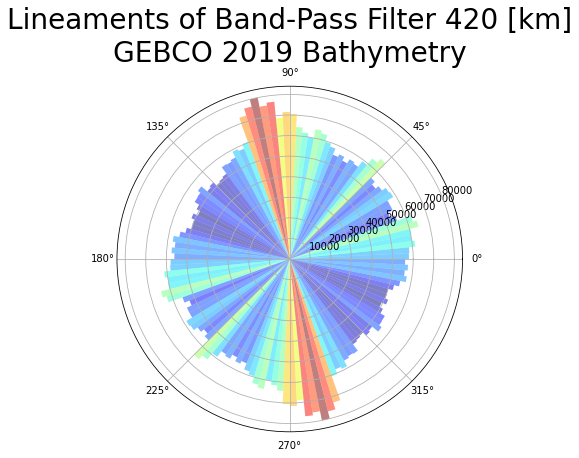

sigmakm 440.0
radius range 17.2 18.0
-112.047607421875 105.761962890625
0...10...20...30...40...50...60...70...80...90...100 - done.
geometries 674
geometries 215219


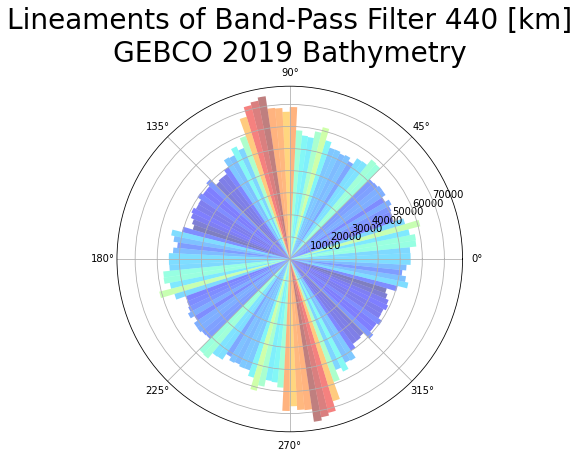

sigmakm 460.0
radius range 18.0 18.8
-110.60888671875 101.721435546875
0...10...20...30...40...50...60...70...80...90...100 - done.
geometries 607
geometries 201987


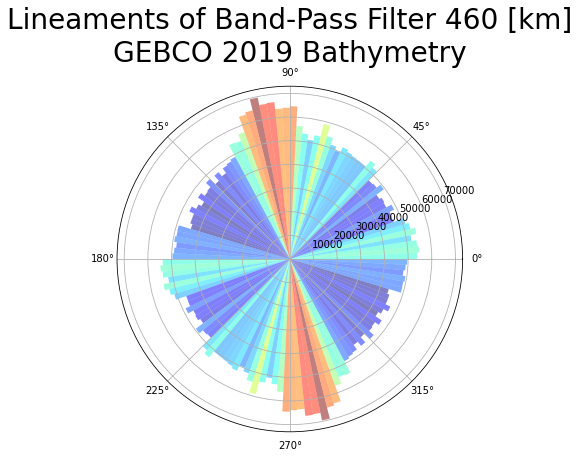

sigmakm 480.0
radius range 18.8 19.6
-108.7900390625 97.744384765625
0...10...20...30...40...50...60...70...80...90...100 - done.
geometries 547
geometries 189962


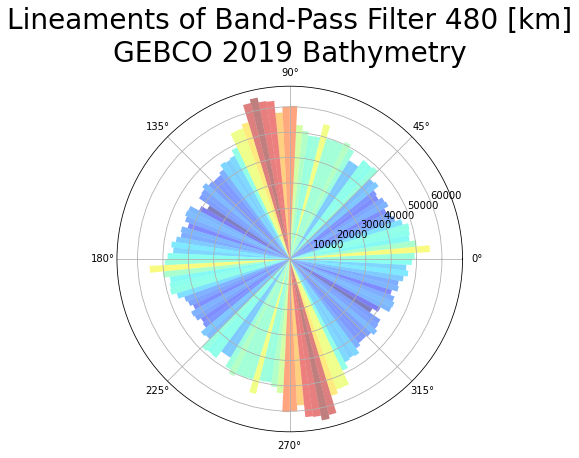

sigmakm 500.0
radius range 19.6 20.4
-106.72265625 94.021484375
0...10...20...30...40...50...60...70...80...90...100 - done.
geometries 509
geometries 179792


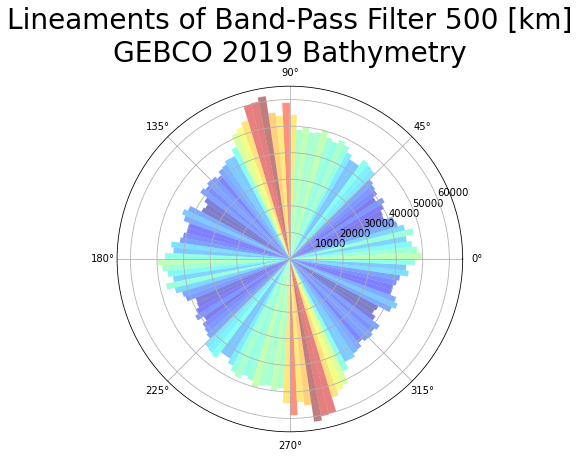

sigmakm 520.0
radius range 20.4 21.2
-104.2734375 92.0684814453125
0...10...20...30...40...50...60...70...80...90...100 - done.
geometries 465
geometries 170033


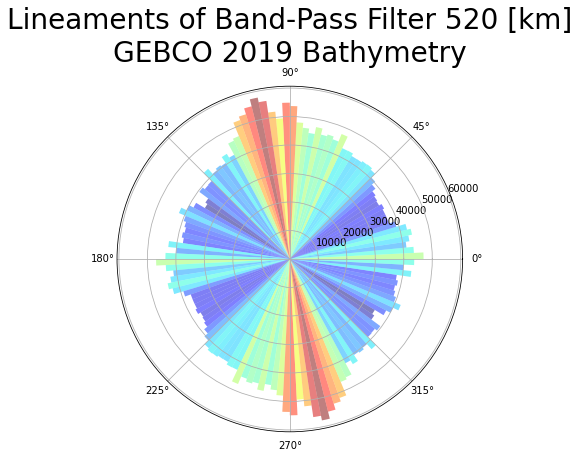

sigmakm 540.0
radius range 21.2 22.0
-101.685302734375 90.09237670898438
0...10...20...30...40...50...60...70...80...90...100 - done.
geometries 425
geometries 161565


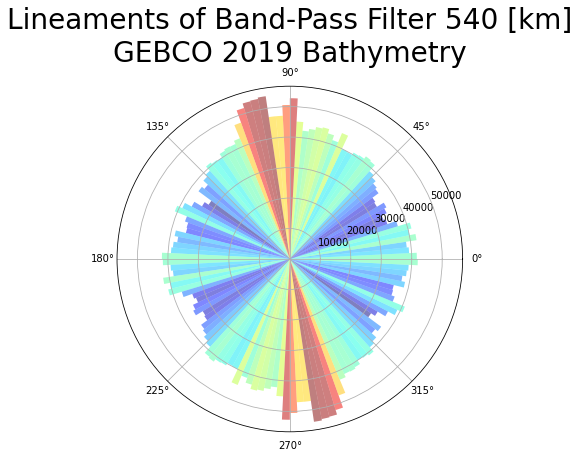

sigmakm 560.0
radius range 22.0 22.8
-98.9249267578125 88.2694320678711
0...10...20...30...40...50...60...70...80...90...100 - done.
geometries 394
geometries 153434


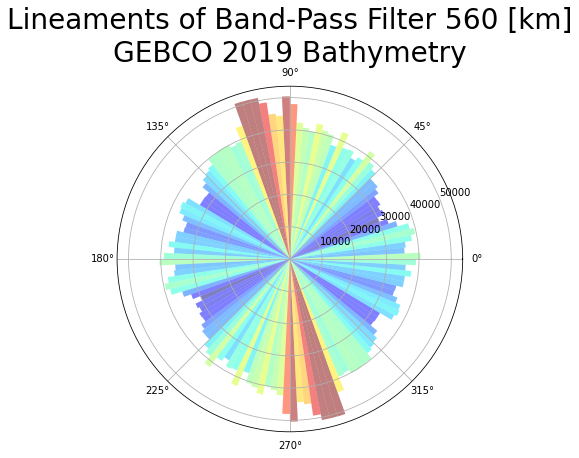

sigmakm 580.0
radius range 22.8 23.6
-96.0181884765625 86.4903564453125
0...10...20...30...40...50...60...70...80...90...100 - done.
geometries 354
geometries 145854


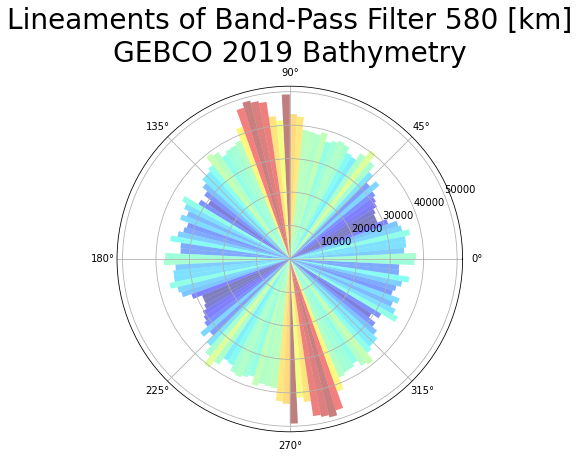

sigmakm 600.0
radius range 23.6 24.4
-93.0196533203125 84.77244567871094
0...10...20...30...40...50...60...70...80...90...100 - done.
geometries 342
geometries 139202


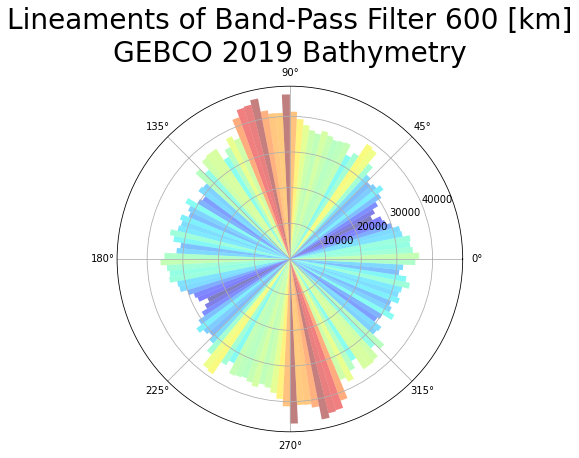

sigmakm 620.0
radius range 24.4 25.2
-89.8695068359375 82.99588012695312
0...10...20...30...40...50...60...70...80...90...100 - done.
geometries 316
geometries 132689


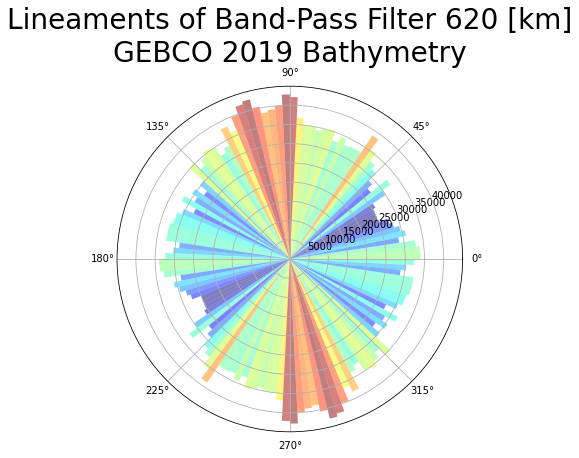

sigmakm 640.0
radius range 25.2 26.0
-86.682861328125 82.137939453125
0...10...20...30...40...50...60...70...80...90...100 - done.
geometries 296
geometries 127169


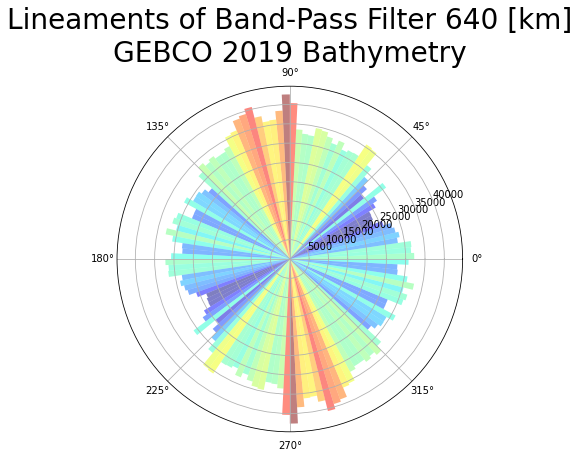

sigmakm 660.0
radius range 26.0 26.8
-83.437744140625 81.752197265625
0...10...20...30...40...50...60...70...80...90...100 - done.
geometries 279
geometries 121792


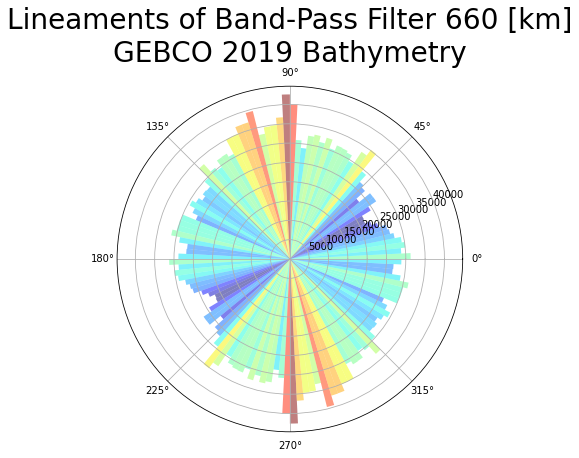

sigmakm 680.0
radius range 26.8 27.6
-80.1431884765625 81.1356201171875
0...10...20...30...40...50...60...70...80...90...100 - done.
geometries 258
geometries 116422


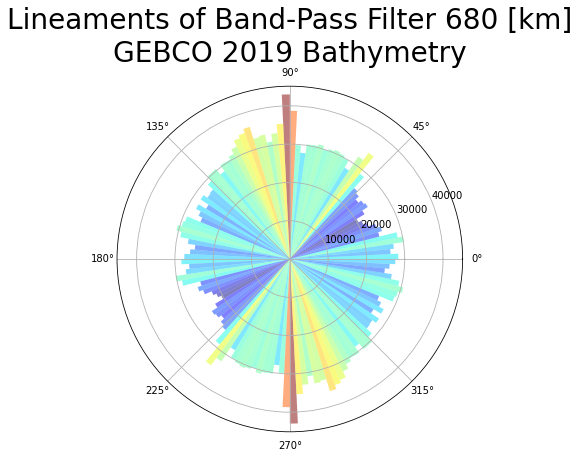

sigmakm 700.0
radius range 27.6 28.4
-76.82763671875 80.3369140625
0...10...20...30...40...50...60...70...80...90...100 - done.
geometries 242
geometries 111732


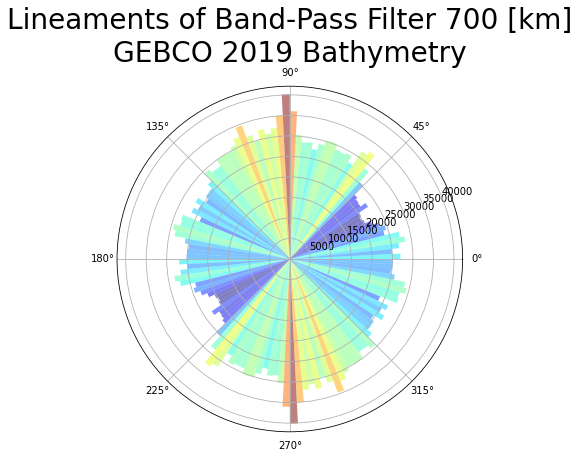

sigmakm 720.0
radius range 28.4 29.2
-73.4925537109375 79.2398681640625
0...10...20...30...40...50...60...70...80...90...100 - done.
geometries 232
geometries 107479


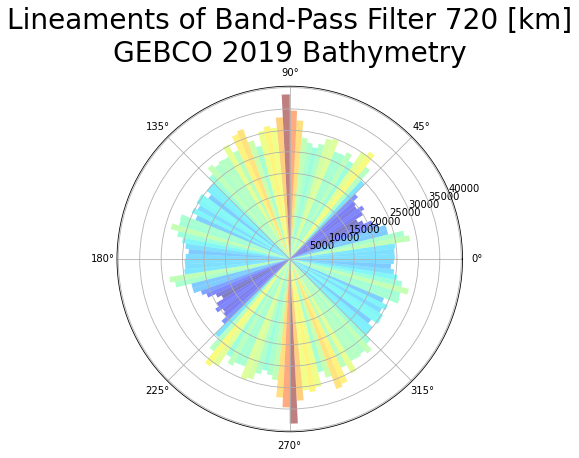

sigmakm 740.0
radius range 29.2 30.0
-70.15576171875 77.9886474609375
0...10...20...30...40...50...60...70...80...90...100 - done.
geometries 225
geometries 103215


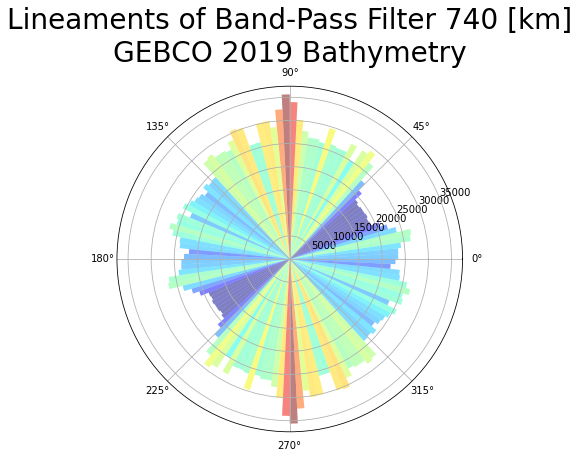

sigmakm 760.0
radius range 30.0 30.8
-66.822021484375 76.580322265625
0...10...20...30...40...50...60...70...80...90...100 - done.
geometries 212
geometries 98848


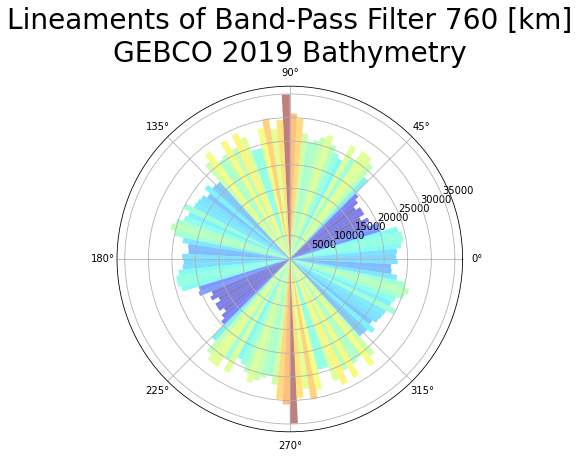

sigmakm 780.0
radius range 30.8 31.6
-63.5068359375 75.034423828125
0...10...20...30...40...50...60...70...80...90...100 - done.
geometries 193
geometries 94816


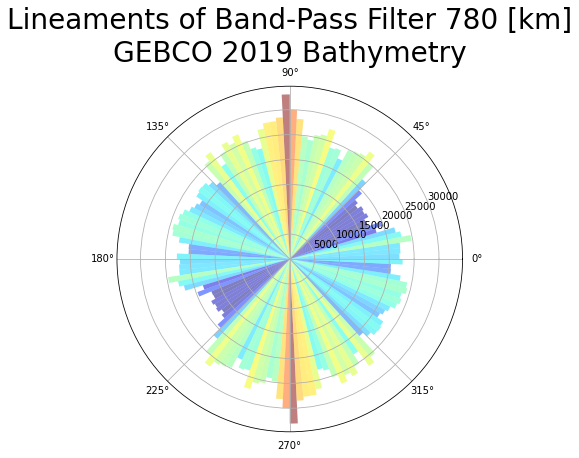

sigmakm 800.0
radius range 31.6 32.4
-60.2032470703125 73.390869140625
0...10...20...30...40...50...60...70...80...90...100 - done.
geometries 187
geometries 91337


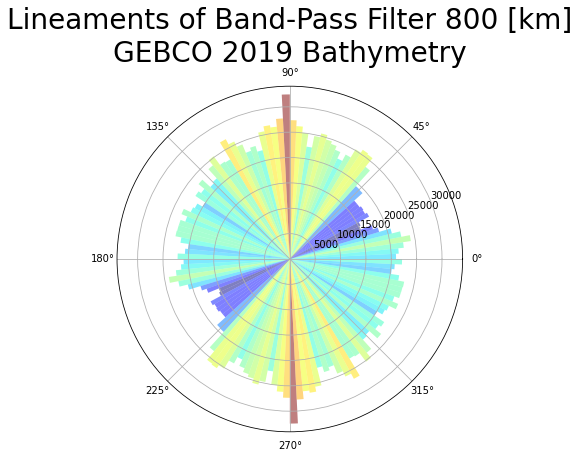

sigmakm 820.0
radius range 32.4 33.2
-58.9462890625 71.58953857421875
0...10...20...30...40...50...60...70...80...90...100 - done.
geometries 175
geometries 87980


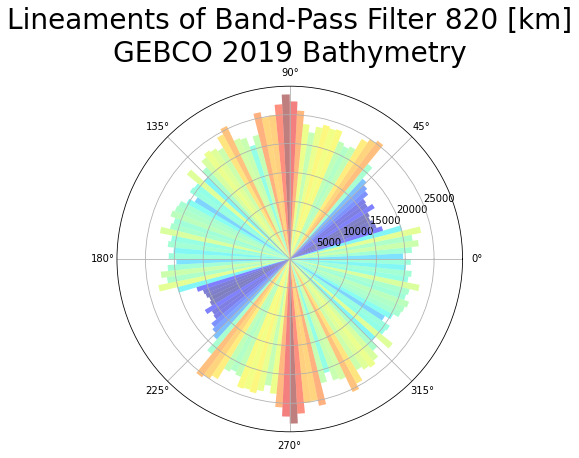

sigmakm 840.0
radius range 33.2 34.0
-58.37158203125 69.7398681640625
0...10...20...30...40...50...60...70...80...90...100 - done.
geometries 168
geometries 85111


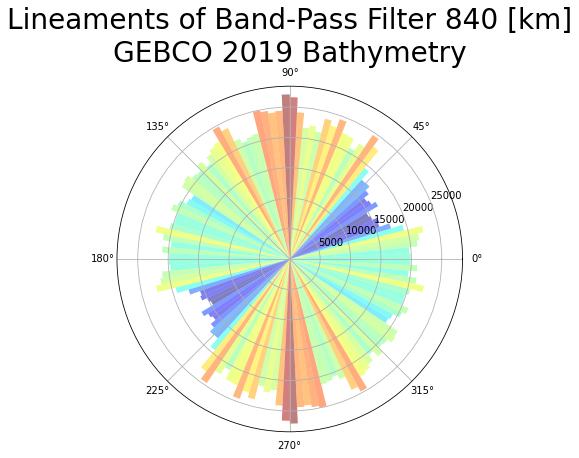

sigmakm 860.0
radius range 34.0 34.8
-57.72802734375 67.84014892578125
0...10...20...30...40...50...60...70...80...90...100 - done.
geometries 161
geometries 82251


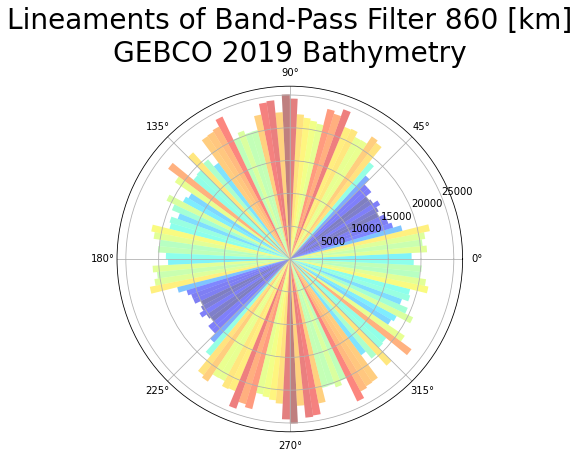

sigmakm 880.0
radius range 34.8 35.6
-57.01171875 65.8978271484375
0...10...20...30...40...50...60...70...80...90...100 - done.
geometries 152
geometries 79560


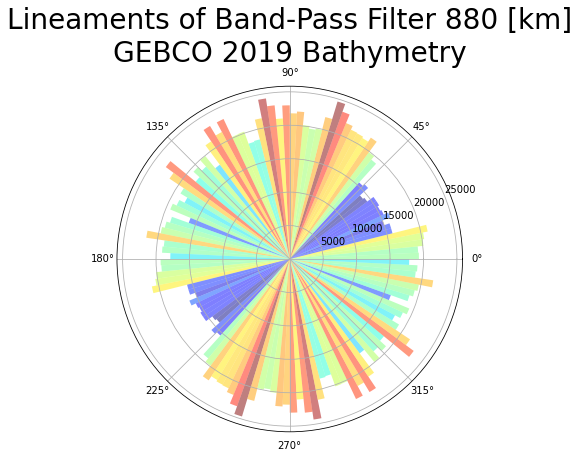

sigmakm 900.0
radius range 35.6 36.4
-56.270751953125 63.958740234375
0...10...20...30...40...50...60...70...80...90...100 - done.
geometries 147
geometries 77193


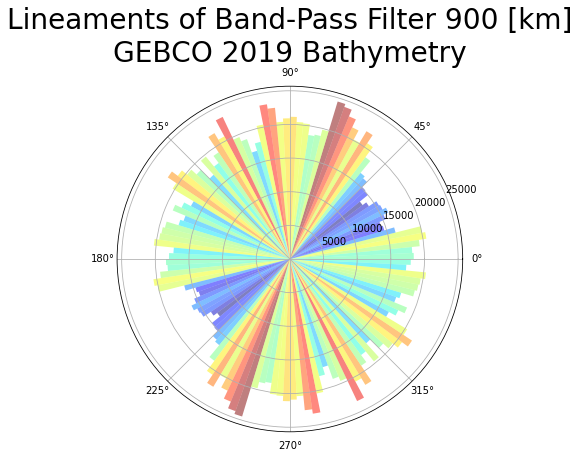

sigmakm 920.0
radius range 36.4 37.2
-55.384033203125 61.9451904296875
0...10...20...30...40...50...60...70...80...90...100 - done.
geometries 141
geometries 74712


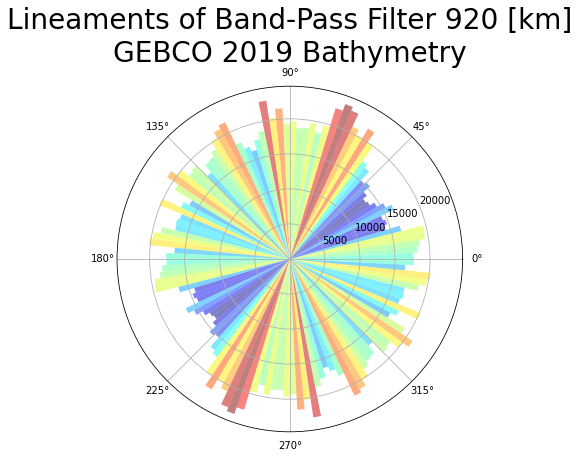

sigmakm 940.0
radius range 37.2 38.0
-54.491943359375 60.134918212890625
0...10...20...30...40...50...60...70...80...90...100 - done.
geometries 134
geometries 72092


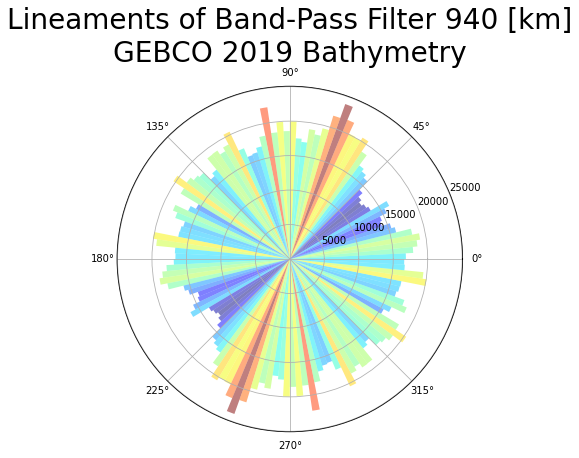

sigmakm 960.0
radius range 38.0 38.8
-53.56201171875 58.922149658203125
0...10...20...30...40...50...60...70...80...90...100 - done.
geometries 127
geometries 69692


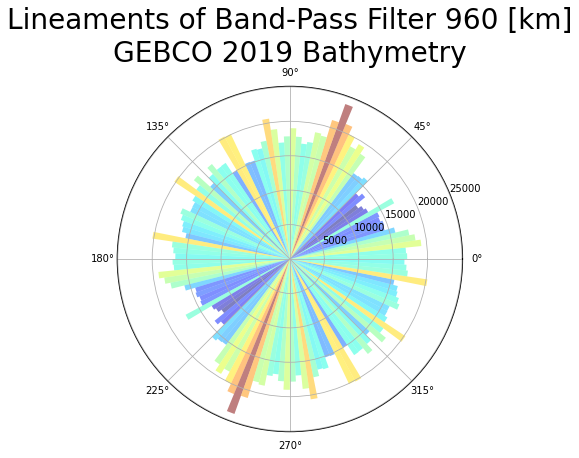

sigmakm 980.0
radius range 38.8 39.6
-52.595458984375 57.728302001953125
0...10...20...30...40...50...60...70...80...90...100 - done.
geometries 122
geometries 67631


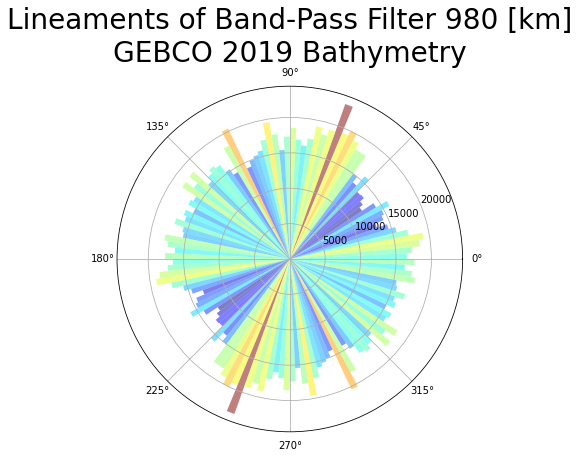

In [5]:
# for inverse geodetic calculation
geod = Geodesic.WGS84

for sigmakm in sigmaskm[1:]:
    print ("sigmakm", sigmakm)
    # roughly estimate filtering radius in pixels
    radius0 = float((sigmakm-dsigmakm/2)/(100*da.lon.diff(dim='lon'))[0])
    radius1 = float((sigmakm+dsigmakm/2)/(100*da.lon.diff(dim='lon'))[0])
    print ("radius range", radius0, radius1)

    raster = raster_filter_range(da, radius0, radius1)
    print (float(raster.min()), float(raster.max()))
    #raster.plot()

    !rm -fr grav_29.1.10min.bandpass.nc
    raster.to_netcdf('GEBCO_2019.15min.bandpass.nc')

    #interval = float(raster.max()-raster.min())/64
    #print ("interval", interval)
    !gdal_contour -a z -i {interval} GEBCO_2019.15min.bandpass.nc GEBCO_2019.15min.bandpass.shp

    df = gpd.read_file('GEBCO_2019.15min.bandpass.shp')
    df.geometry = df.geometry.apply(lambda geom: MultiLineString([geom]) if geom.geom_type == 'LineString' else geom)
    df = df.explode("geometry").reset_index(drop=True)
    print ("geometries",len(df))

    df['geom'] = df.geometry.apply(lambda geom: segmentize(geom))
    df = df.explode("geom").reset_index(drop=True)
    df = df.rename(columns={'geometry':'_','geom': 'geometry'}).drop(['_'], axis=1)
    print ("geometries",len(df))

    df['angle'] = df.geometry.apply(angle_radian)
    df['length'] = df.geometry.apply(length_km)

    # symmetrize directions
    _df = df.copy()
    _df['angle'] = df.angle.apply(lambda radian: radian-np.pi if radian>=0 else np.pi+radian)
    df_sym = pd.concat([df, _df])

    # Pandas 0.25.0+
    angles = np.linspace(-np.pi, np.pi, 128+1, endpoint=True)
    labels = (angles[1:] + angles[:-1])/2
    df_sym['sector'] = labels[np.digitize(df_sym.angle, angles)-1]
    df_sym_sector = df_sym.groupby(['sector']).agg(num = ('sector','count'),length = ('length','sum')).reset_index()

    # force square figure and square axes looks better for polar, IMO
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], polar=True)

    theta = df_sym_sector.sector.values
    radii = df_sym_sector.length.values
    width = np.diff(angles)[0]

    bars = ax.bar(theta, radii, width=width, bottom=0.0)
    for r,bar in zip(radii, bars):
        bar.set_facecolor( cm.jet((r-np.min(radii))/(np.max(radii)-np.min(radii))))
        bar.set_alpha(0.5)

    plt.title(f'Lineaments of Band-Pass Filter {int(sigmakm): >3} [km]\nGEBCO 2019 Bathymetry', fontsize=28)
    plt.savefig(f'Lineaments of Band-Pass Filter {int(sigmakm):0>3} [km] GEBCO 2019 Bathymetry.jpg', \
                bbox_inches='tight', dpi=100, pil_kwargs={'quality': 85})
    plt.show()